<a href="https://colab.research.google.com/github/Matheus2608/Data-Science/blob/main/Identificador%20de%20Pragas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Créditos dos dados das pestes das plantações de Tomate
https://data.mendeley.com/datasets/s62zm6djd2/1 ou em https://github.com/Matheus2608/Data-Science/blob/main/Tomato%20pest%20image%20enhancement.7z

Huang , Mei-Ling; Chuang, Tzu Chin (2020), “A database of eight common tomato pest images”, Mendeley Data, V1, doi: 10.17632/s62zm6djd2.1
- Tratam-se de oito pragas em plantações de tomates
- Originalmente essa base dados possuia 609 imagens das pragas, mas com técnicas de augmentation como: 
 - Rotação de 90 graus, 180 graus, 270 graus 
  - Flip horizontal
  - Flip vertical 
  - Cortes


## Bibliotecas necessárias para o modelo da CNN e plotagem de gráficos e imagens

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from keras.layers.core import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
!ls

 sample_data  'Tomato pest image enhancement.7z'


## Descompactando o arquivo

In [3]:
!pip install py7zr

     |████████████████████████████████| 76 kB 4.2 MB/s 
     |████████████████████████████████| 2.4 MB 32.1 MB/s 
     |████████████████████████████████| 2.0 MB 42.2 MB/s 
     |████████████████████████████████| 357 kB 45.9 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 131 kB 47.7 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 


In [4]:
import py7zr
#import brotlicffi as brotli
with py7zr.SevenZipFile("Tomato pest image enhancement.7z", mode='r') as z:
        z.extractall("dataset")

In [5]:
%cd "dataset/"

/content/dataset


## Separando os dados em conjuntos de treinamento e teste

In [6]:
data_dir = 'Tomato pest image enhancement'

In [7]:
img_height,img_width=299, 299
batch_size=32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4263 files belonging to 8 classes.
Using 3411 files for training.


In [8]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4263 files belonging to 8 classes.
Using 852 files for validation.


## Exemplos das imagens das pragas com seus respectivas classes em formato de número

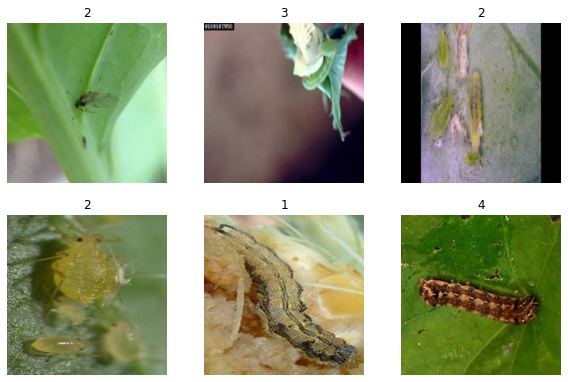

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(str(int(labels[i])))
    plt.axis("off")

## Transferência de Aprendizagem do Modelo Resnet-50

In [11]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='max',classes=8,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [12]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(8, activation='softmax'))
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 8)                 4104      
                                                                 
Total params: 24,640,904
Trainable params: 1,053,192
Non-trainable params: 23,587,712
_________________________________________________________________


## Avaliação do modelo usando algumas métricas importantes

In [13]:
from keras import backend as K

def recall_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_metric(y_true, y_pred):
    precision = precision_metric(y_true, y_pred)
    recall = recall_metric(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

metrics = ['accuracy', recall_metric, precision_metric, f1_metric]

In [14]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss=loss, metrics=metrics)
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
107/107 [==============================] - 74s 543ms/step - loss: 4.2974 - accuracy: 0.6327 - recall_metric: 1.2131 - precision_metric: 1.1335 - f1_metric: 1.1708 - val_loss: 0.6137 - val_accuracy: 0.7946 - val_recall_metric: 1.2440 - val_precision_metric: 1.1761 - val_f1_metric: 1.2083
Epoch 2/10
107/107 [==============================] - 54s 499ms/step - loss: 0.4204 - accuracy: 0.8631 - recall_metric: 1.1637 - precision_metric: 1.0749 - f1_metric: 1.1164 - val_loss: 0.3582 - val_accuracy: 0.8674 - val_recall_metric: 1.1477 - val_precision_metric: 1.0794 - val_f1_metric: 1.1112
Epoch 3/10
107/107 [==============================] - 54s 498ms/step - loss: 0.1751 - accuracy: 0.9408 - recall_metric: 1.1080 - precision_metric: 1.0150 - f1_metric: 1.0585 - val_loss: 0.3465 - val_accuracy: 0.8756 - val_recall_metric: 1.1629 - val_precision_metric: 1.0862 - val_f1_metric: 1.1223
Epoch 4/10
107/107 [==============================] - 54s 499ms/step - loss: 0.1349 - accuracy: 0.9496 

In [15]:
history.history.keys() 

dict_keys(['loss', 'accuracy', 'recall_metric', 'precision_metric', 'f1_metric', 'val_loss', 'val_accuracy', 'val_recall_metric', 'val_precision_metric', 'val_f1_metric'])

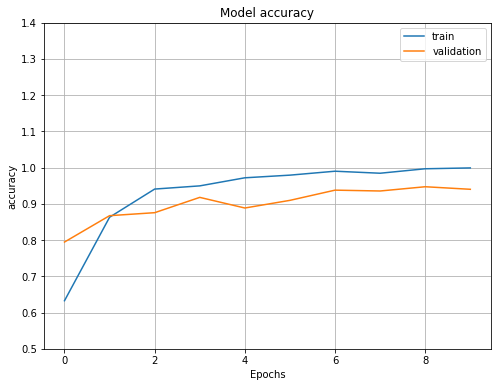

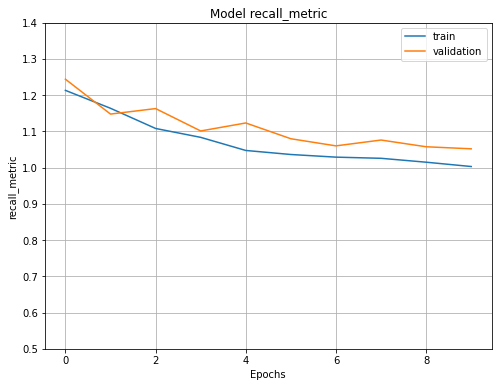

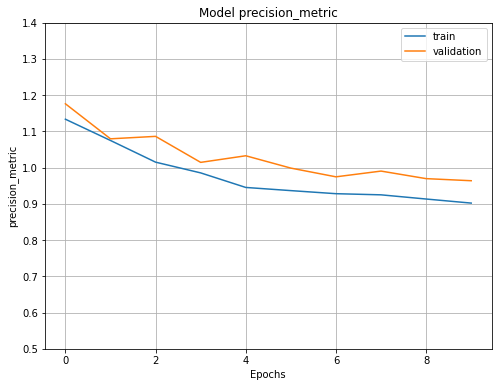

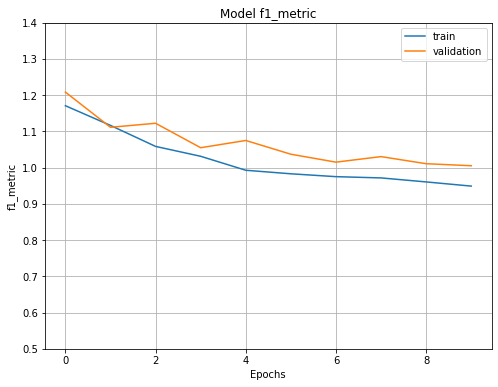

In [16]:
def grafico_metrica(metrica, metrica_validacao):
  plt.figure(figsize=(8, 6))
  plt.plot(history.history[metrica])
  plt.plot(history.history[metrica_validacao])
  plt.axis(ymin=0.5,ymax=1.4)
  plt.grid()
  plt.title(f"Model {metrica}")
  plt.ylabel(metrica)
  plt.xlabel('Epochs')
  plt.legend(['train', 'validation'])
  plt.show()

grafico_metrica('accuracy', 'val_accuracy')
grafico_metrica('recall_metric', 'val_recall_metric')
grafico_metrica('precision_metric', 'val_precision_metric')
grafico_metrica('f1_metric', 'val_f1_metric')


# Observação:
#### Por meio das métricas, observa-se que o modelo faz predições bem satisfatórias tanto no conjunto de treinamento tanto no conjunto de teste/validação e não está sobreajustado. Portanto, trata-se de um bom modelo para predizere as pragas destas plantações.
#### Porém também é necessário visualizar se ela está tendo um desempenho ruim para alguma das classes de pragas

In [19]:
train_ds, val_ds

(<BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [21]:
train_ds.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [91]:
class_names = train_ds.class_names
print(class_names)

classes = {key: [] for key in class_names} #primeira lista eh das labels e a outra da predicao
print(classes)

['BA', 'HA', 'MP', 'SE', 'SL', 'TP', 'TU', 'ZC']
{'BA': [], 'HA': [], 'MP': [], 'SE': [], 'SL': [], 'TP': [], 'TU': [], 'ZC': []}


In [92]:
for images, labels in val_ds:
  for i in range(len(labels)): #numero de batches
    label = int(labels[i])
    classe = class_names[label]
    image = np.expand_dims(images[i],axis=0)
    pred = resnet_model.predict(image)
    output_class = class_names.index(class_names[np.argmax(pred)])
    classes[classe].append(output_class)
  #   print(classe)
  #   print(str(label))
  #   print(output_class)
  # break

In [93]:
soma = 0
for images, labels in val_ds:
  soma += len(labels)
soma

852

In [94]:
soma = 0
for key in classes.keys():
  soma += len(classes[key])
soma

852

In [96]:
i = 0
for key in classes.keys():
  classes[key] = classes[key], [i] * len(classes[key])
  i += 1

In [100]:
len(classes['BA'][0]), classes['BA'][1].count(0)

(77, 77)